/root/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 1000/10000, Train Loss: 0.0231, Test Loss: 0.0235
Epoch 2000/10000, Train Loss: 0.0224, Test Loss: 0.0235
Epoch 3000/10000, Train Loss: 0.0224, Test Loss: 0.0234
Epoch 4000/10000, Train Loss: 0.0225, Test Loss: 0.0234
Epoch 5000/10000, Train Loss: 0.0221, Test Loss: 0.0234
Epoch 6000/10000, Train Loss: 0.0223, Test Loss: 0.0234
Epoch 7000/10000, Train Loss: 0.0218, Test Loss: 0.0234
Epoch 8000/10000, Train Loss: 0.0226, Test Loss: 0.0234
Epoch 9000/10000, Train Loss: 0.0225, Test Loss: 0.0235
Epoch 10000/10000, Train Loss: 0.0223, Test Loss: 0.0234


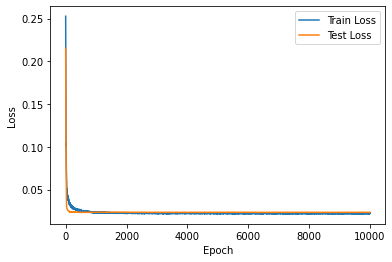

torch.Size([108, 1, 10])

In [23]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# 读取数据集
data = pd.read_csv("/root/2023mcm/new_data.csv")

from pykalman import KalmanFilter
# 选取需要处理的列
cols = [6, 7, 8, 9, 10, 11, 12]
data_sub = data.iloc[:, cols].values

# 创建Kalman滤波器
kf = KalmanFilter(initial_state_mean=data_sub[0], n_dim_obs=7)
# 进行滤波
filtered_state_means, filtered_state_covariances = kf.filter(data_sub)

# 将滤波结果保存回原数据中
data.iloc[:, cols] = filtered_state_means
# 准备数据集
X = data.iloc[:, [1,12, 13, 14, 15, 16, 17, 19,20,21]].values
y = data.iloc[:, 5:12].values

scaler_X = MinMaxScaler()
scaler_y=MinMaxScaler()
X = scaler_X.fit_transform(X)
y=scaler_y.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 将数据转换为张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

class BiGRUAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, l1=0, l2=0.001):
        super(BiGRUAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc2 = nn.Linear(hidden_size*2, output_size)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size*2),
            nn.Tanh(),
            nn.Linear(hidden_size*2, 1),
            nn.Softmax(dim=1)
        )
        self.l1 = nn.L1Loss(l1) if l1 > 0 else None
        self.l2 = nn.MSELoss(l2) if l2 > 0 else None

    def forward(self, x):
        x = x.view(len(x), 1, -1) 
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # num_layers*2 because we are using a bi-directional GRU
        out, _ = self.bigru(x, h0)
        out = self.fc1(out)
        attention_weights = self.attention(out)
        out = torch.sum(out * attention_weights, dim=1)
        out = self.fc2(out)
        if self.l1 is not None:
            reg_loss = self.l1(self.fc2.weight, torch.zeros_like(self.fc2.weight))
            out += reg_loss
        if self.l2 is not None:
            reg_loss = self.l2(self.fc2.weight, torch.zeros_like(self.fc2.weight))
            out += reg_loss
        return out






# 训练函数
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        # 训练模型
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 计算训练集和测试集上的损失
        train_loss.append(total_loss / len(train_loader))
        with torch.no_grad():
            model.eval()
            test_loss.append(get_loss(model, criterion, test_loader))

        # 打印损失
        if (epoch+1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")

    return train_loss, test_loss
def get_loss(model, criterion, dataloader):
    total_loss = 0
    total_count = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        total_loss += loss.item() * X.size(0)
        total_count += X.size(0)
    return total_loss / total_count

# 设置超参数
input_size = 10
hidden_size = 32
num_layers = 1
output_size = 7
num_epochs =10000
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型、损失函数和优化器
model = MLP(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.001)

from torch.utils.data import DataLoader, TensorDataset

# 将数据转换为 Dataset 对象
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 创建 DataLoader 对象，指定批次大小
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练模型
train_loss, test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)


#可视化训练过程中的损失值
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 将测试集输入到模型中，得到预测值
y_pred = model(X_test.to(device)).detach().cpu().numpy()
np.shape(X_test.view(len(X_test), 1, -1))

Dimension 1: MSE = 20.143956411734308, RMSE = 4.488201912986347, MAE = 2.926384882823029
Dimension 2: MSE = 2566.3225620318485, RMSE = 50.65888433465396, MAE = 39.38136291133733
Dimension 3: MSE = 29759.35412709017, RMSE = 172.5089972351882, MAE = 141.6382489023291
Dimension 4: MSE = 4477.156812774507, RMSE = 66.91155963489797, MAE = 50.51818599724993
Dimension 5: MSE = 11736.150860389867, RMSE = 108.33351679138764, MAE = 87.20449054605815
Dimension 6: MSE = 9200.502432280457, RMSE = 95.91924953981061, MAE = 79.0731236475289
Dimension 7: MSE = 3362.252636760055, RMSE = 57.98493456717922, MAE = 43.2123789258725


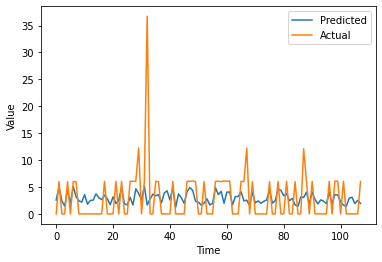

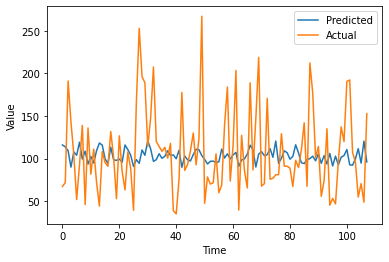

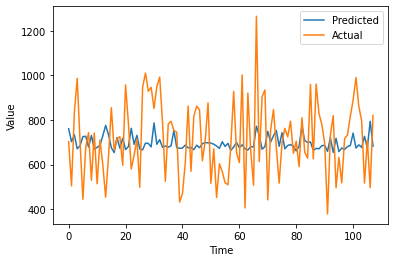

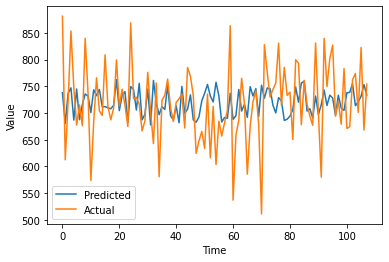

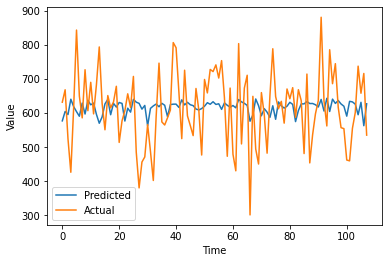

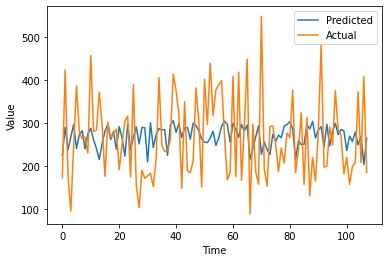

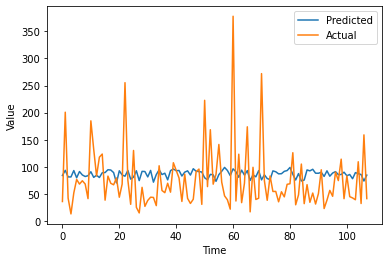

array([[   0.        ,   67.06683594,  703.03421903,  881.27403157,
         631.70290216,  172.26208527,   35.72788542],
       [   6.00059991,   71.63287389,  504.78026713,  612.41811628,
         668.13846899,  423.32880547,  200.7370395 ],
       [   0.        ,  191.07780935,  832.69277909,  721.79857515,
         524.37475741,  177.67065549,   42.10650798],
       [   0.        ,  143.10014641,  986.54271069,  853.64361095,
         426.15559154,   95.05767387,   12.82494801],
       [   6.00059991,  104.91128709,  703.65221676,  748.5432869 ,
         616.4907452 ,  249.01968046,   51.56790962],
       [   0.        ,   51.77004517,  444.48234782,  677.35138128,
         843.32123497,  386.20793867,   76.54339339],
       [   6.00059991,   92.21933036,  678.11119149,  715.16628031,
         649.50595209,  277.72757045,   67.93030437],
       [   6.00059991,  138.90081743,  743.10326463,  676.23932159,
         585.71366569,  263.64128672,   74.09129261],
       [   0.        ,  

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#scaler.fit(y)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)
df = pd.read_csv("/root/2023mcm/result.csv")
# Create the "GRU" column and assign the predicted values to it
# 计算每个维度的 MSE、RMSE 和 MAE
for i in range(7):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print("Dimension {}: MSE = {}, RMSE = {}, MAE = {}".format(i+1, mse, rmse, mae))
# 将每个维度的预测值和实际值都分别可视化
for i in range(7):
    plt.plot(y_pred[:, i], label="Predicted")
    plt.plot(y_test[:, i], label="Actual")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()
y_test

In [ ]:
import stats
#对于给定的输入 X，进行预测
X_new = np.array([[620,0, 1, 0, 3, 1, 1, 1,0.09318,0.063]]) # 举例子
#scaler.fit(X_new)
X_new = scaler_X.transform(X_new) # 归一化
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
model.eval() # 模型评估模式
with torch.no_grad():
    y_pred = model(X_new_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
    #scaler.fit(y)
    y_pred=scaler_y.inverse_transform(y_pred)
    print("预测值为：", y_pred)

In [ ]:
from scipy import stats

def get_confidence_interval(model, X, alpha=0.05):
    """
    给定模型和输入，计算预测值和置信区间
    :param model: 已训练的模型
    :param X: 输入，形状为 (n_samples, n_features)
    :param alpha: 置信水平，默认为 0.05
    :return: 预测值、置信区间下界、置信区间上界
    """
    model.eval() # 模型评估模式
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
        y_pred = model(X_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
        n_samples = len(X)
        df = n_samples - model.hidden_size - 1 # 自由度
        se = np.sqrt(np.sum((model(X_tensor).cpu().numpy() - y)**2) / df) # 标准误差
        t = stats.t.ppf(1 - alpha/2, df) # t 分布的分位数
        lower = y_pred - t * se # 置信区间下界
        upper = y_pred + t * se # 置信区间上界
    return y_pred, lower, upper

y_pred, lower, upper = get_confidence_interval(model, X_new)
print("预测值为：", y_pred)
print("置信区间为：[{}, {}]".format(lower, upper))